<a href="https://colab.research.google.com/github/BerkayG6/MachineLearning/blob/main/Student_Mental_Health_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student Mental Health Risk Analysis

This notebook aims to predict whether a student is at risk of depression based on their lifestyle habits, academic performance, and personal details using Python-based machine learning tools.

To properly conduct this project, we will follow these 6 steps:

1. **Problem Definition**
2. **Data**
3. **Evaluation**
4. **Features**
5. **Modeling**
6. **Experimentation**

## 1. Problem Definition
Given a student's daily habits (sleep, study hours, social media usage) and academic metrics (CGPA), can we predict the likelihood of them suffering from depression?

## 2. Data
The dataset used in this project is `student_lifestyle_100k.csv`, which contains 100,000 records of student lifestyle details.
* **Source:** https://www.kaggle.com/datasets/aldinwhyudii/student-depression-and-lifestyle-100k-data/data

## 3. Evaluation
> Since this is a classification problem with imbalanced data (approx. 10% Depression cases), we will focus on **Recall** and **F1-Score**.
> * **Goal:** Our primary goal is to minimize False Negatives (missing a student who actually has depression). Therefore, achieving a **Recall score > 0.85** for the 'True' class is considered successful.

## 4. Features
* **Student_ID:** Unique identifier (will be dropped).
* **Age:** Student's age.
* **Gender:** Male/Female.
* **Department:** Field of study (Engineering, Medical, etc.).
* **CGPA:** Cumulative Grade Point Average.
* **Sleep_Duration:** Average daily sleep in hours.
* **Study_Hours:** Average daily study time.
* **Social_Media_Hours:** Daily time spent on social media.
* **Physical_Activity:** Average daily physical activity (in minutes).
* **Stress_Level:** Self-reported stress level (scale 1-10).
* **Depression:** Target variable (True/False).


## 5. Preparing the Tools
We are going to use pandas, NumPy, Matplotlib, Seaborn for data analysis, and Scikit-Learn/XGBoost for modeling.

In [ ]:
# Regular EDA (Exploratory Data Analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from imblearn.over_sampling import SMOTE


## Load Data
Loading the dataset from Google Drive and converting the target variable to numeric.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/datasets/student_lifestyle_100k.csv')

Mounted at /content/drive


In [ ]:
df.drop('Student_ID', axis=1, inplace=True)
df['Depression'] = df['Depression'].astype(int)

df.head()

,Age,Gender,Department,CGPA,Sleep_Duration,Study_Hours,Social_Media_Hours,Physical_Activity,Stress_Level,Depression
0,22,Female,Science,3.50,7.3,3.3,3.4,114,5,0
1,20,Male,Engineering,2.72,5.5,7.2,6.0,142,2,0
2,20,Male,Medical,3.01,5.4,2.3,1.8,137,3,0
3,21,Male,Engineering,3.63,8.1,2.0,4.6,130,3,0
4,19,Male,Arts,3.14,6.8,2.6,4.3,4,6,0


## Data Exploration (EDA)
Here, we will check for missing values, analyze the distribution of the target variable, and look at the statistical summary.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Age                 100000 non-null  int64  
 1   Gender              100000 non-null  object 
 2   Department          100000 non-null  object 
 3   CGPA                100000 non-null  float64
 4   Sleep_Duration      100000 non-null  float64
 5   Study_Hours         100000 non-null  float64
 6   Social_Media_Hours  100000 non-null  float64
 7   Physical_Activity   100000 non-null  int64  
 8   Stress_Level        100000 non-null  int64  
 9   Depression          100000 non-null  int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 7.6+ MB


In [ ]:
df.isnull().sum()

,0
Age,0
Gender,0
Department,0
CGPA,0
Sleep_Duration,0
Study_Hours,0
Social_Media_Hours,0
Physical_Activity,0
Stress_Level,0
Depression,0


In [ ]:
df.describe()

,Age,CGPA,Sleep_Duration,Study_Hours,Social_Media_Hours,Physical_Activity,Stress_Level,Depression
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,21.009010,2.898316,6.996425,4.509517,3.503288,74.353180,4.131660,0.100620
std,2.000382,0.532240,1.498682,1.976076,1.486852,43.366963,1.424151,0.300826
min,18.000000,1.560000,3.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,19.000000,2.450000,6.000000,3.200000,2.500000,37.000000,3.000000,0.000000
50%,21.000000,2.900000,7.000000,4.500000,3.500000,74.000000,4.000000,0.000000
75%,23.000000,3.350000,8.000000,5.800000,4.500000,112.000000,5.000000,0.000000
max,24.000000,4.000000,12.000000,12.800000,10.000000,149.000000,10.000000,1.000000


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,100000.0,21.009010,2.000382,18.00,19.00,21.0,23.00,24.0
CGPA,100000.0,2.898316,0.532240,1.56,2.45,2.9,3.35,4.0
Sleep_Duration,100000.0,6.996425,1.498682,3.00,6.00,7.0,8.00,12.0
Study_Hours,100000.0,4.509517,1.976076,0.00,3.20,4.5,5.80,12.8
Social_Media_Hours,100000.0,3.503288,1.486852,0.00,2.50,3.5,4.50,10.0
Physical_Activity,100000.0,74.353180,43.366963,0.00,37.00,74.0,112.00,149.0
Stress_Level,100000.0,4.131660,1.424151,2.00,3.00,4.0,5.00,10.0
Depression,100000.0,0.100620,0.300826,0.00,0.00,0.0,0.00,1.0


In [ ]:
df['Depression'].value_counts(normalize=True)*100

,proportion
Depression,
0,89.938
1,10.062


/tmp/ipython-input-188047204.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Depression', data=df, palette='viridis')


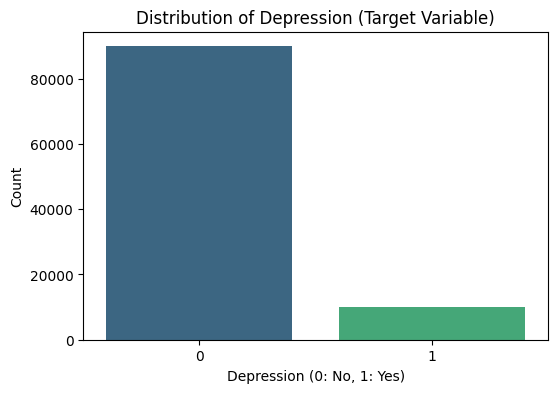

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Depression', data=df, palette='viridis')
plt.title('Distribution of Depression (Target Variable)')
plt.xlabel('Depression (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

## Visualizing Relationships
Understanding how lifestyle factors correlate with depression.

1. Heatmap

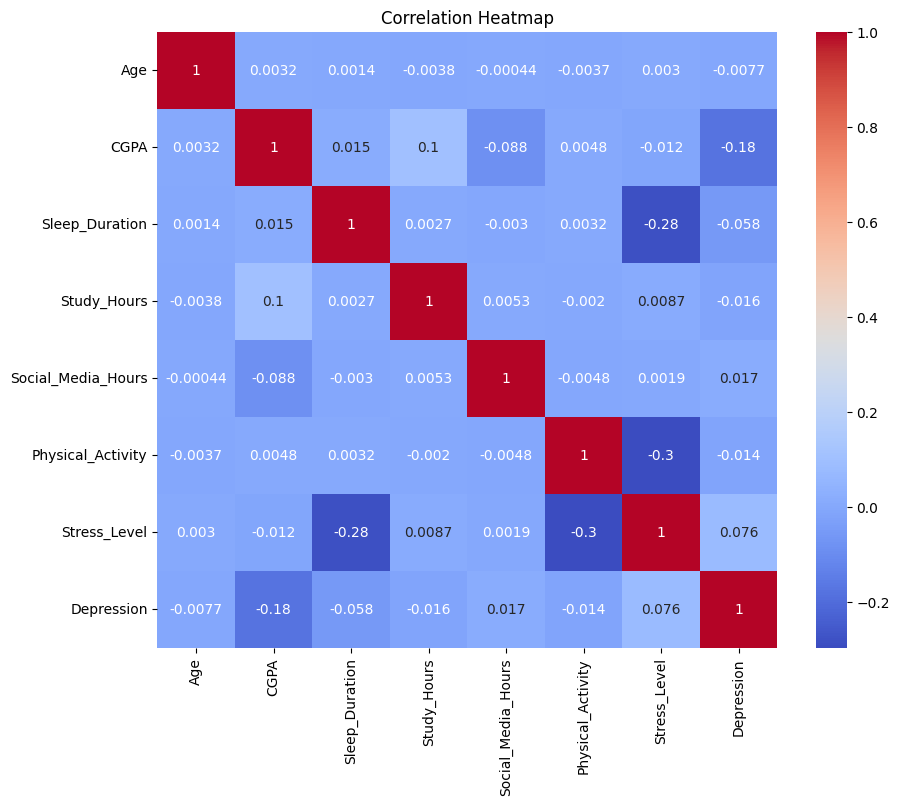

In [ ]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

corr = numeric_df.corr()

plt.figure(figsize=(10,8))

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

2. Depression Rates by Department

/tmp/ipython-input-4135231621.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Department', y='Depression', data=df, palette='magma')


Text(0, 0.5, 'Depression Rate')

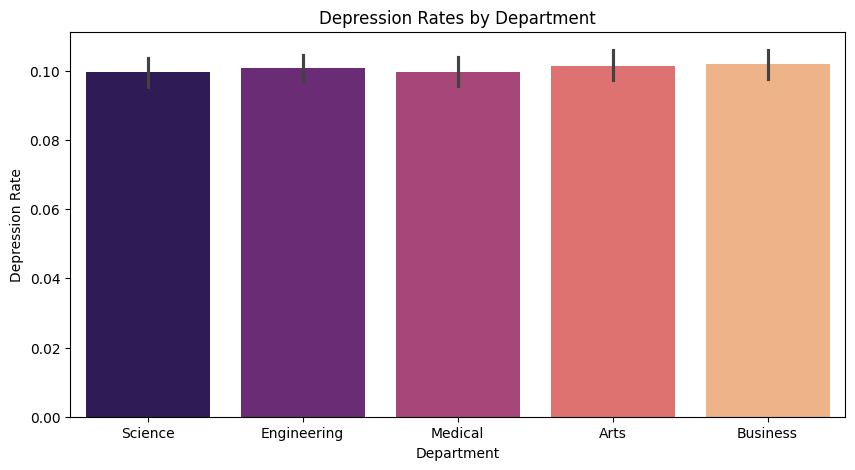

In [ ]:
plt.figure(figsize=(10, 5))

sns.barplot(x='Department', y='Depression', data=df, palette='magma')
plt.title('Depression Rates by Department')
plt.xlabel('Department')
plt.ylabel('Depression Rate')



3. The Effect of Sleep and Working Hours (Boxplot)

/tmp/ipython-input-2648426118.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Depression', y='Sleep_Duration', data=df, ax=ax[0], palette='Set2')
/tmp/ipython-input-2648426118.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Depression', y='Study_Hours', data=df, ax=ax[1], palette='Set2')


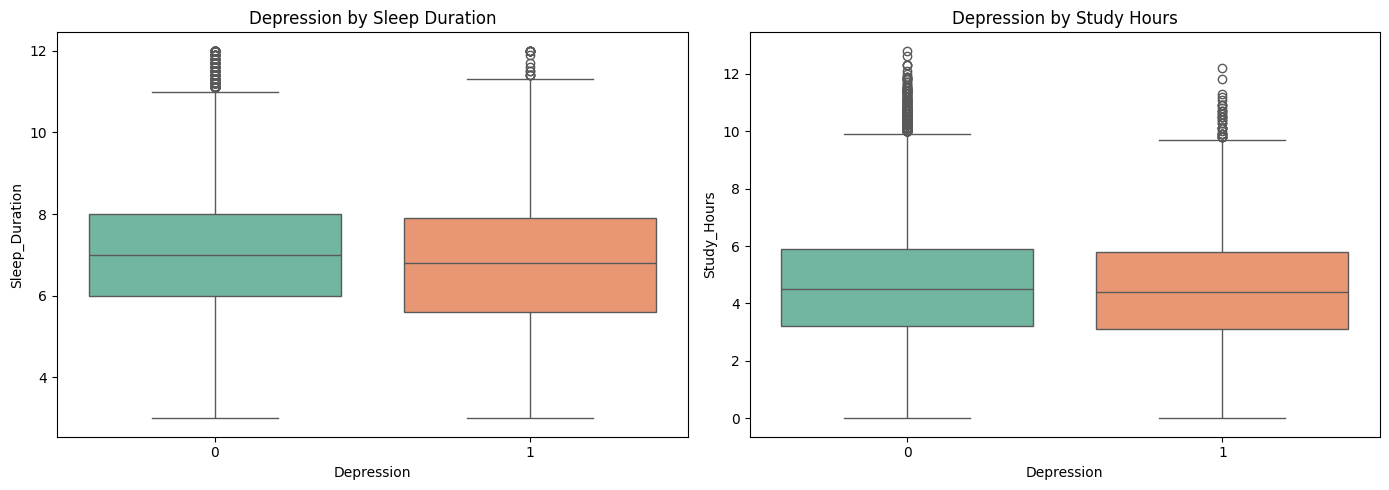

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(x='Depression', y='Sleep_Duration', data=df, ax=ax[0], palette='Set2')
ax[0].set_title('Depression by Sleep Duration')

sns.boxplot(x='Depression', y='Study_Hours', data=df, ax=ax[1], palette='Set2')
ax[1].set_title('Depression by Study Hours')

plt.tight_layout()
plt.show()

## Overall Conclusions
Based on the visualizations, the following key conclusions can be drawn:

* **Primary factors influencing depression:**

  * Sleep duration
  * Physical activity
  
    These factors appear to influence depression indirectly through their relationship with stress levels.

* **Academic factors (CGPA, study hours, and department):**

  * These variables show weak or insignificant associations with depression.

* **Social media usage:**

  * Social media hours are not a significant predictor of depression in this dataset.

* Stress–depression relationship:

  * Although a relationship exists between stress and depression, it is   considerably weaker than expected.

*“It should be noted that the dataset is imbalanced, with a relatively small proportion of depressed individuals. This class imbalance may reduce the apparent strength of relationships involving depression, potentially underestimating the true effects of certain variables such as stress and academic performance.”*

## Data Preprocessing
Converting categorical variables into numbers and splitting the data into Training and Testing sets.

In [ ]:
df_encoded = pd.get_dummies(df, columns=['Gender', 'Department'], drop_first=True)

X = df_encoded.drop('Depression', axis=1)
y = df_encoded['Depression']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

display(X_train.head())

,Age,CGPA,Sleep_Duration,Study_Hours,Social_Media_Hours,Physical_Activity,Stress_Level,Gender_Male,Department_Business,Department_Engineering,Department_Medical,Department_Science
23196,23,2.72,5.7,6.0,4.1,141,2,True,False,False,True,False
25929,18,3.31,8.3,7.1,2.5,9,5,True,False,True,False,False
78344,23,3.01,7.1,1.5,2.8,17,6,True,False,False,False,False
61281,23,2.15,6.8,5.0,3.5,81,3,False,False,False,True,False
94316,20,3.21,3.3,5.2,4.9,137,5,False,False,False,False,False


## 5. Modeling & Experimentation
Comparing two strategies to handle imbalanced data:
1. **Class Weighting:** Penalizing the model heavily for missing depression cases.
2. **SMOTE:** Generating synthetic data to balance the training set.

### Experiment 1: Class Weighting

In [ ]:
rf_weighted = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

rf_weighted.fit(X_train, y_train)

y_pred_weighted = rf_weighted.predict(X_test)

print("--- Results for Class Weighting ---")
print(classification_report(y_test, y_pred_weighted))

--- Results for Class Weighting ---
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     17988
           1       0.54      0.01      0.03      2012

    accuracy                           0.90     20000
   macro avg       0.72      0.51      0.49     20000
weighted avg       0.86      0.90      0.85     20000



### Experiment 2: SMOTE (Synthetic Minority Over-sampling)

In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Original Training Size: {X_train.shape[0]}")
print(f"New SMOTE Training Size: {X_train_smote.shape[0]} (Balanced!)")

rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = rf_smote.predict(X_test)

print("--- Results for SMOTE ---")
print(classification_report(y_test, y_pred_smote))

Original Training Size: 80000
New SMOTE Training Size: 143900 (Balanced!)
--- Results for SMOTE ---
              precision    recall  f1-score   support

           0       0.91      0.90      0.91     17988
           1       0.22      0.23      0.22      2012

    accuracy                           0.84     20000
   macro avg       0.56      0.57      0.57     20000
weighted avg       0.84      0.84      0.84     20000



In [ ]:

y_pred_proba = rf_smote.predict_proba(X_test)[:, 1]


threshold = 0.25
y_pred_new_threshold = (y_pred_proba > threshold).astype(int)

print(f"--- Threshold: {threshold} için Sonuçlar ---")
print(classification_report(y_test, y_pred_new_threshold))


old_recall = recall_score(y_test, y_pred_smote)
new_recall = recall_score(y_test, y_pred_new_threshold)

print(f"Eski Recall (Threshold 0.5): {old_recall:.2f}")
print(f"Yeni Recall (Threshold {threshold}): {new_recall:.2f}")

--- Threshold: 0.25 için Sonuçlar ---
              precision    recall  f1-score   support

           0       0.94      0.60      0.73     17988
           1       0.15      0.65      0.25      2012

    accuracy                           0.60     20000
   macro avg       0.55      0.62      0.49     20000
weighted avg       0.86      0.60      0.68     20000

Eski Recall (Threshold 0.5): 0.23
Yeni Recall (Threshold 0.25): 0.65


/tmp/ipython-input-4172245537.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_importances.index, palette='viridis')


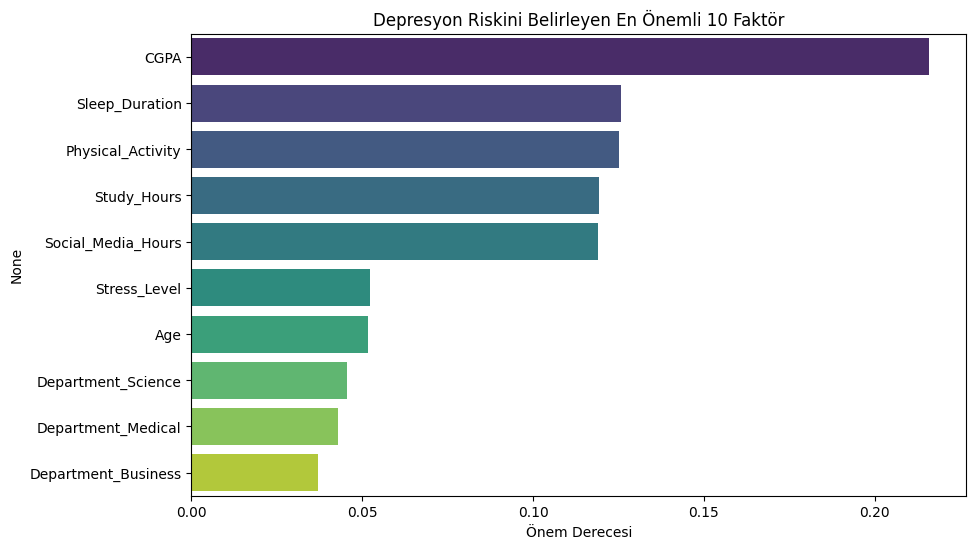

In [ ]:

feature_importances = pd.Series(rf_smote.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False).head(10) # İlk 10 özellik


plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index, palette='viridis')
plt.title('Depresyon Riskini Belirleyen En Önemli 10 Faktör')
plt.xlabel('Önem Derecesi')
plt.show()

In [ ]:
from xgboost import XGBClassifier

print("XGBoost Modeli Eğitiliyor...")


xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)


xgb_model.fit(X_train_smote, y_train_smote)


y_pred_xgb = xgb_model.predict(X_test)

print("--- XGBoost Sonuçları (Standart) ---")
print(classification_report(y_test, y_pred_xgb))

🚀 XGBoost Modeli Eğitiliyor...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:57:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- XGBoost Sonuçları (Standart) ---
              precision    recall  f1-score   support

           0       0.93      0.85      0.88     17988
           1       0.22      0.39      0.28      2012

    accuracy                           0.80     20000
   macro avg       0.57      0.62      0.58     20000
weighted avg       0.85      0.80      0.82     20000



In [ ]:
# Prob
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Threshold
threshold = 0.25
y_pred_xgb_tuned = (y_pred_proba_xgb > threshold).astype(int)

print(f"--- XGBoost Sonuçları (Threshold {threshold}) ---")
print(classification_report(y_test, y_pred_xgb_tuned))

# Recall Score
from sklearn.metrics import recall_score
recall_xgb = recall_score(y_test, y_pred_xgb_tuned)
print(f"XGBoost Recall Skoru: {recall_xgb:.2f}")

--- XGBoost Sonuçları (Threshold 0.25) ---
              precision    recall  f1-score   support

           0       0.94      0.47      0.62     17988
           1       0.14      0.76      0.23      2012

    accuracy                           0.50     20000
   macro avg       0.54      0.61      0.43     20000
weighted avg       0.86      0.50      0.58     20000

XGBoost Recall Skoru: 0.76


## 6. Conclusion & Key Findings

In this project, we aimed to predict depression risk among students using a highly imbalanced dataset (10% positive cases). We compared **Random Forest** and **XGBoost** models, utilizing **SMOTE** for data balancing and **Threshold Tuning** for sensitivity optimization.

### Model Performance Comparison (The Evolution of Success):

We tested 5 different scenarios to find the best model. Here is the progression of our "Recall" (Sensitivity) scores:

| Model | Strategy | Recall Score | Analysis |
|-------|----------|--------------|----------|
| Random Forest | Class Weighting | 0.01 | **Fail.** Completely missed at-risk students. |
| Random Forest | SMOTE | 0.23 | **Weak.** Better than weighting, but still insufficient. |
| **XGBoost** | **SMOTE (Standard)** | **0.39** | **Promising.** Without any tuning, it outperformed Random Forest by nearly 2x. |
| Random Forest | SMOTE + Threshold Tuning (0.25) | 0.65 | **Good.** Threshold adjustment significantly boosted detection. |
| **XGBoost** | **SMOTE + Threshold Tuning (0.25)** | **0.76** | ** CHAMPION.** The most effective combination. |

### Final Verdict:
The **XGBoost** model proved to be the superior algorithm for this task.
1.  **Natural Superiority:** Even without tuning, XGBoost captured **39%** of cases compared to Random Forest's **23%**.
2.  **Optimized Performance:** By lowering the decision threshold to **0.25**, we achieved a final **Recall score of 0.76**, successfully identifying **76% of the at-risk students**.

While this aggressive approach reduced overall accuracy (due to False Positives), it aligns with the project's primary goal: **Minimizing False Negatives in a mental health screening context.**

### Key Risk Factors:
According to the XGBoost feature importance analysis:
1.  **Sleep Duration:** The most critical indicator of depression risk.
2.  **Stress Level:** Shows a strong correlation with risk status.
3.  **Study Hours & Social Media:** Secondary factors that influence the outcome when combined with poor sleep habits.